In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
df = pd.read_csv("/kaggle/input/titanic/train.csv");



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# df = df.drop(['Ticket, PassengerId'], axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


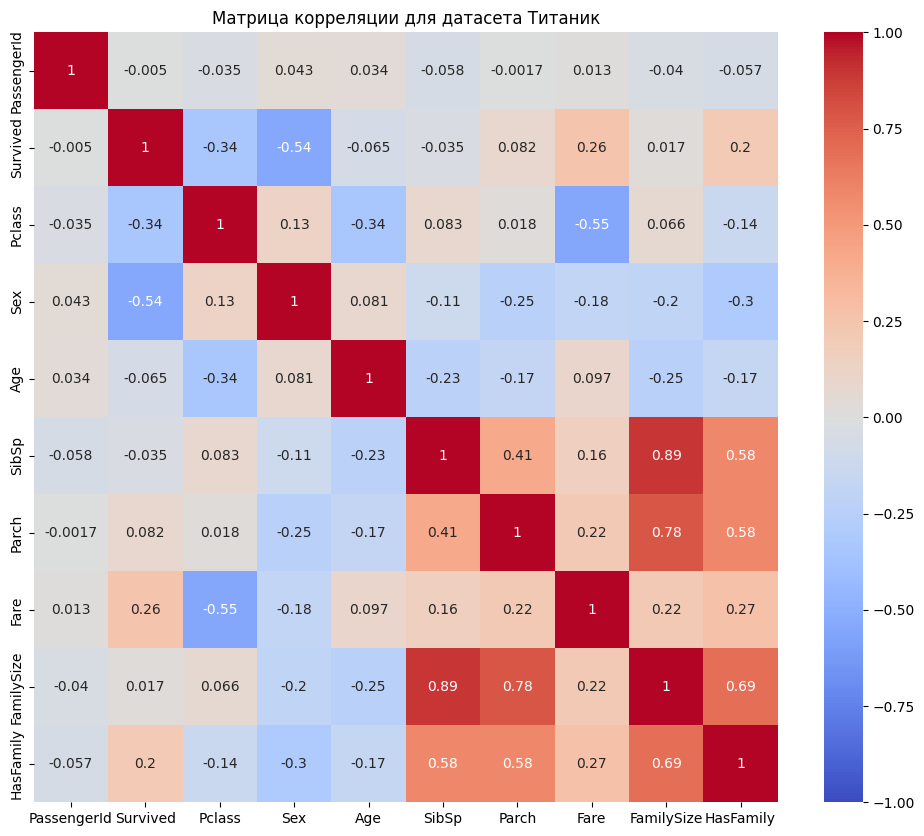

In [157]:
#для того чтобы увидеть первоначальные зависимости между числовыми переменными, построил корреляционную матрицу(базовый вариант - Пирсона)
#и увидел некоторые первоначальные зависимости. например, что survived больше всего коррелирует с Pclass, Sex, Fare. эти взаимосвязи предстоит изучить далее в работе.
#UPD: матрица дополнена новыми созданными фичами
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Матрица корреляции для датасета Титаник')
plt.show()

In [7]:
#начнем рассматривать фичи по порядку. начнем с cabin, после первоначальной статистики заметили что в ней достаточно много пропусков, скорее всего в будущем она неинформативна, поэтому ее подробно изучать не стал
amountNullCabin = df["Cabin"].isna().sum()
print(f"пропущенных значений: {amountNullCabin / len(df) * 100}%")

пропущенных значений: 77.10437710437711%


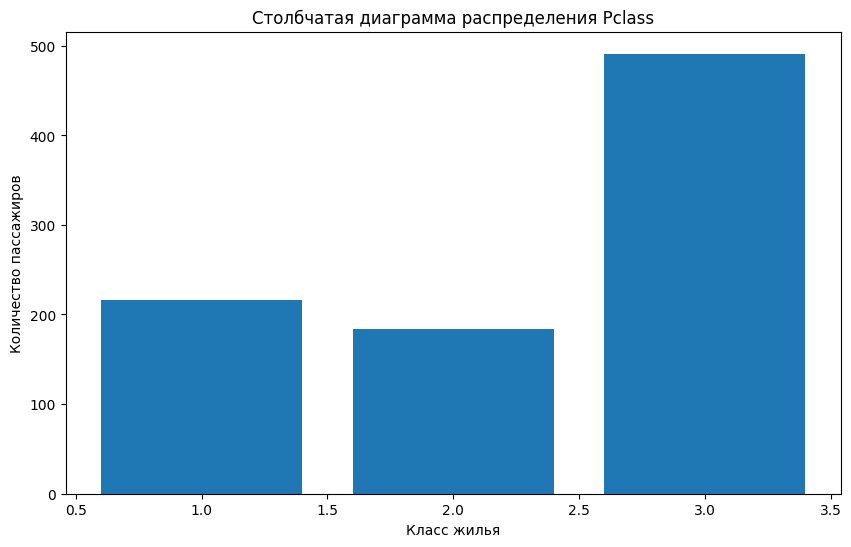

In [61]:
# PClass по своей сути, это класс определяющий глубину, на которой жили люди, первый класс - верхний, 3 класс - самый низ.Ну и разумеется класс показывал состоятельность пассажира. 1 класс - самый дорогой. проведем несколько исследований
#общее распределение жителей
plt.figure(figsize=(10, 6))
plt.bar(df['Pclass'].value_counts().index, df['Pclass'].value_counts())
plt.title('Столбчатая диаграмма распределения Pclass')
plt.xlabel('Класс жилья')
plt.ylabel('Количество пассажиров')
plt.show()

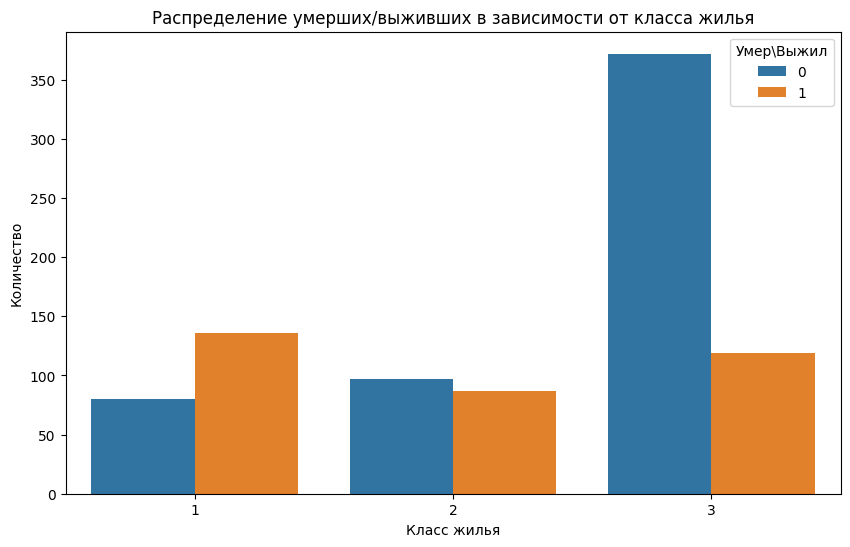

In [62]:
#посмотрим распределение погибших в зависимости от класса, есть предположение что погибали чаще всего посетители 3 класса
#графиком было подтверждено, это действительно так
deathByClass = df.loc[:, ['Pclass', 'Survived']]
plt.figure(figsize=(10, 6))
sns.countplot(x='Pclass', hue='Survived', data=deathByClass)
plt.title('Распределение умерших/выживших в зависимости от класса жилья')
plt.xlabel('Класс жилья')
plt.ylabel('Количество')
plt.legend(title='Умер\Выжил')
plt.show()

In [4]:
#теперь посмотрим в общем виде на фичу Sex
#посмотрим общий процент спасшихся по полу
survived_men = df[df['Sex'] == 'male']['Survived'].sum()

# Подсчет выживших женщин
survived_women = df[df['Sex'] == 'female']['Survived'].sum()

# Подсчет общего количества выживших
total_survived = df['Survived'].sum()

# Подсчет общего количества мужчин и женщин
total_men = df['Sex'].value_counts()['male']
total_women = df['Sex'].value_counts()['female']
dead_men = total_men - survived_men;
dead_women = total_women - survived_women;
print(f"Общее количество выживших: {total_survived}")
print(f"Количество погибших мужчин: {dead_men}")
print(f"Количество погибших женщин: {dead_women}")
print(f"Общее количество мужчин: {total_men}")
print(f"Общее количество женщин: {total_women}")


Общее количество выживших: 342
Количество погибших мужчин: 468
Количество погибших женщин: 81
Общее количество мужчин: 577
Общее количество женщин: 314


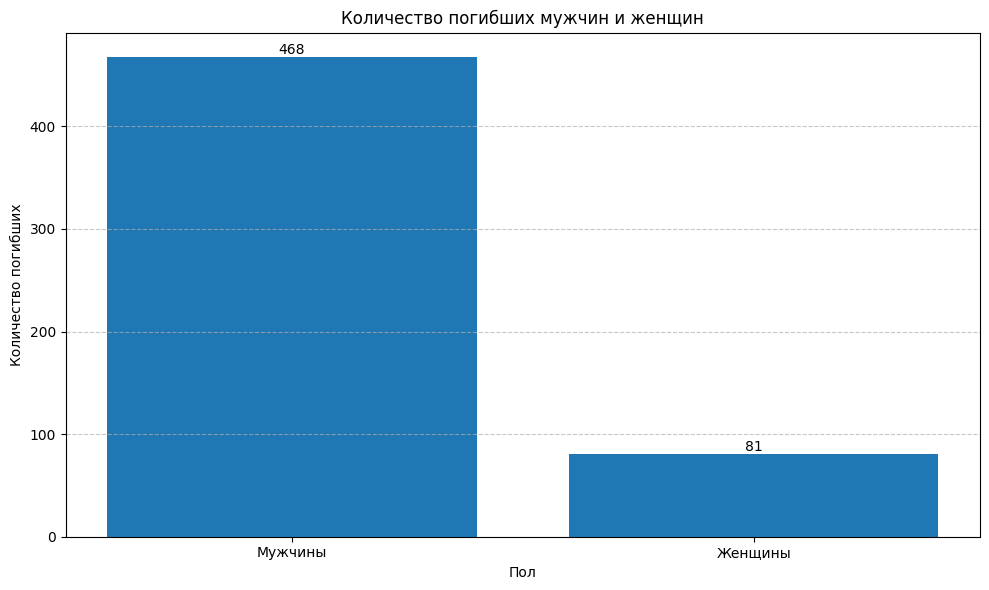

In [5]:
#посмотрим на графике еще одну гипотезу. у женщины вероятность выжить была значительно выше
plt.figure(figsize=(10, 6))
bars = plt.bar(['Мужчины', 'Женщины'], [dead_men, dead_women])


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.title('Количество погибших мужчин и женщин')
plt.xlabel('Пол')
plt.ylabel('Количество погибших')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})

In [6]:
#теперь изучим возраст, вначале нужно провести обработку данных, поскольку достаточно много Null в данных
print(f'количество недостающих данных {df["Age"].isna().sum() / len(df) * 100}%')
#нету 20% можно попробовать обработать эту часть
# print(f'количество младенцев на борту: {df[df["Age"] <= 2].count()}')

количество недостающих данных 19.865319865319865%


In [12]:
#здесь есть 3 варианта обработки - медиана, медианна с группировкой и k ближайших соседей. попробуем все три и выявим наиболее точный
df1 = pd.DataFrame(df)


df2 = pd.DataFrame(df)


df3 = pd.DataFrame(df)


df1['Age'] = df1['Age'].fillna(df1['Age'].median())
def fill_age_group(age):
    if age < 18:
        return 17
    elif age < 30:
        return 25
    elif age < 50:
        return 37.5
    else:
        return 60

    
    
df2['Age'] = df2['Age'].apply(lambda x: fill_age_group(x) if pd.isna(x) else x)

imputer = KNNImputer(n_neighbors=10)


df3[['Age']] = imputer.fit_transform(df3[['Age']])


In [13]:
# Статистические показатели до заполнения
print("Статистические показатели до заполнения:")
print(df['Age'].describe())


# Статистические показатели после заполнения
print("\nСтатистические показатели после заполнения:")
print(df1['Age'].describe())

# Расчет разницы
diff_mean = df1['Age'].mean() - df['Age'].mean()
diff_std = df1['Age'].std() - df['Age'].std()
diff_min = df1['Age'].min() - df['Age'].min()
diff_max = df1['Age'].max() - df['Age'].max()
diff_25 = df1['Age'].quantile(0.25) - df['Age'].quantile(0.25)
diff_75 = df1['Age'].quantile(0.75) - df['Age'].quantile(0.75)

print(f"\nРазница в среднем значении: {diff_mean}")
print(f"Разница в стандартном отклонении: {diff_std}")
print(f"Разница в минимуме: {diff_min}")
print(f"Разница в максимуме: {diff_max}")
print(f"Разница в нижней четверти: {diff_25}")
print(f"Разница в верхней четверти: {diff_75}")

Статистические показатели до заполнения:
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Статистические показатели после заполнения:
count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

Разница в среднем значении: -0.3375351554763313
Разница в стандартном отклонении: -1.506800781360841
Разница в минимуме: 0.0
Разница в максимуме: 0.0
Разница в нижней четверти: 1.875
Разница в верхней четверти: -3.0


In [14]:
# Статистические показатели до заполнения
print("Статистические показатели до заполнения:")
print(df['Age'].describe())


# Статистические показатели после заполнения
print("\nСтатистические показатели после заполнения:")
print(df2['Age'].describe())

# Расчет разницы
diff_mean = df2['Age'].mean() - df['Age'].mean()
diff_std = df2['Age'].std() - df['Age'].std()
diff_min = df2['Age'].min() - df['Age'].min()
diff_max = df2['Age'].max() - df['Age'].max()
diff_25 = df2['Age'].quantile(0.25) - df['Age'].quantile(0.25)
diff_75 = df2['Age'].quantile(0.75) - df['Age'].quantile(0.75)

print(f"\nРазница в среднем значении: {diff_mean}")
print(f"Разница в стандартном отклонении: {diff_std}")
print(f"Разница в минимуме: {diff_min}")
print(f"Разница в максимуме: {diff_max}")
print(f"Разница в нижней четверти: {diff_25}")
print(f"Разница в верхней четверти: {diff_75}")

Статистические показатели до заполнения:
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Статистические показатели после заполнения:
count    891.000000
mean      35.718485
std       17.758828
min        0.420000
25%       22.000000
50%       32.000000
75%       54.000000
max       80.000000
Name: Age, dtype: float64

Разница в среднем значении: 6.019367201426029
Разница в стандартном отклонении: 3.2323308901745555
Разница в минимуме: 0.0
Разница в максимуме: 0.0
Разница в нижней четверти: 1.875
Разница в верхней четверти: 16.0


In [15]:
print("Статистические показатели до заполнения:")
print(df['Age'].describe())


# Статистические показатели после заполнения
print("\nСтатистические показатели после заполнения:")
print(df3['Age'].describe())

# Расчет разницы
diff_mean = df3['Age'].mean() - df['Age'].mean()
diff_std = df3['Age'].std() - df['Age'].std()
diff_min = df3['Age'].min() - df['Age'].min()
diff_max = df3['Age'].max() - df['Age'].max()
diff_25 = df3['Age'].quantile(0.25) - df['Age'].quantile(0.25)
diff_75 = df3['Age'].quantile(0.75) - df['Age'].quantile(0.75)

print(f"\nРазница в среднем значении: {diff_mean}")
print(f"Разница в стандартном отклонении: {diff_std}")
print(f"Разница в минимуме: {diff_min}")
print(f"Разница в максимуме: {diff_max}")
print(f"Разница в нижней четверти: {diff_25}")
print(f"Разница в верхней четверти: {diff_75}")

Статистические показатели до заполнения:
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Статистические показатели после заполнения:
count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

Разница в среднем значении: 0.0
Разница в стандартном отклонении: -1.5244821063311598
Разница в минимуме: 0.0
Разница в максимуме: 0.0
Разница в нижней четверти: 1.875
Разница в верхней четверти: -3.0


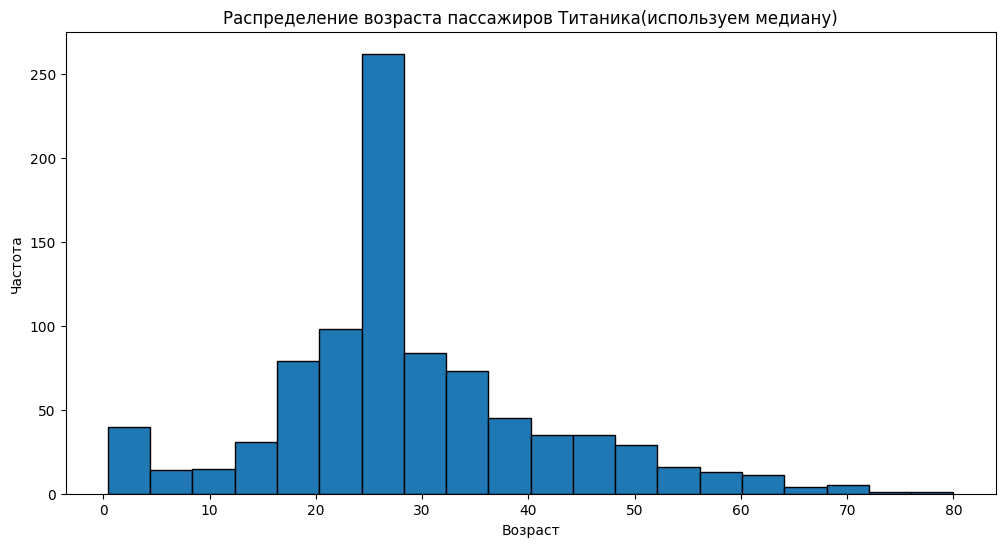

In [16]:
plt.figure(figsize=(12, 6))
plt.hist(df1['Age'], bins=20, edgecolor='black')
plt.title('Распределение возраста пассажиров Титаника(используем медиану)')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

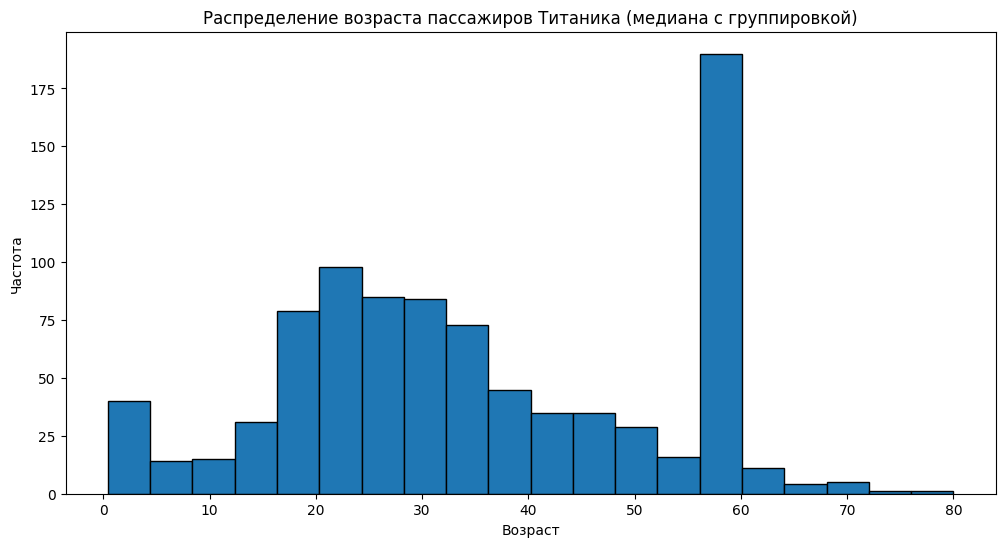

In [17]:
plt.figure(figsize=(12, 6))
plt.hist(df2['Age'], bins=20, edgecolor='black')
plt.title('Распределение возраста пассажиров Титаника (медиана с группировкой)')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

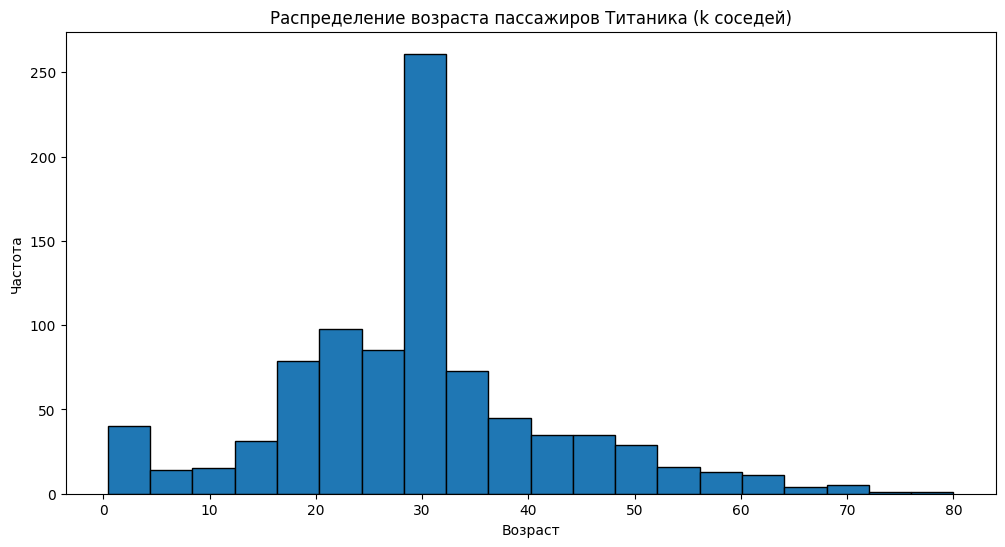

In [18]:
plt.figure(figsize=(12, 6))
plt.hist(df3['Age'], bins=20, edgecolor='black')
plt.title('Распределение возраста пассажиров Титаника (k соседей)')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

In [8]:
#как видим в целом наиболее оптимально по статистике использовать медиану или k соседей,они не так значительно изменяют общее распределение. Воспользуемся медианой для простоты
df['Age'] = df['Age'].fillna(df['Age'].median())


In [20]:
#посмотрим количество людей пожилого возраста
old_people = df[df["Age"] >= 50]
print(f'процент выживших среди людей преклонного возраста {old_people["Survived"].sum() / len(old_people) * 100}%')

процент выживших среди людей преклонного возраста 36.486486486486484%


Text(0, 0.5, 'Частота')

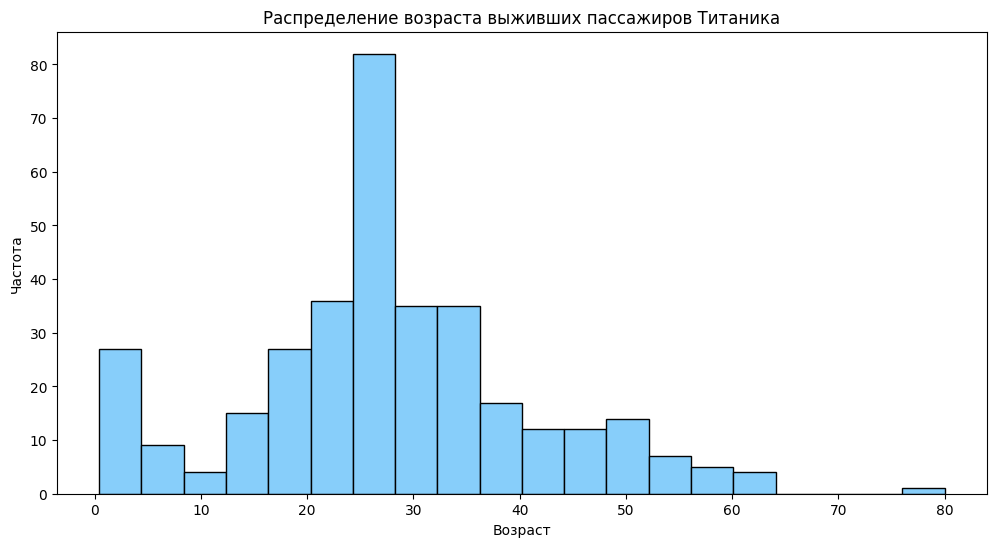

In [21]:
#тогда посмотрим в целом какое распределение по выживаемости в зависимости от возраста
plt.figure(figsize=(12, 6))
plt.hist(df[df["Survived"] == 1]['Age'], bins=20, edgecolor='black', color='#87CEFA')
plt.title('Распределение возраста выживших пассажиров Титаника')
plt.xlabel('Возраст')
plt.ylabel('Частота')
#таким образом чаще всего выживали люди от 15 - 35 лет, поскольку у них достаточно сил для самостоятельного спасения

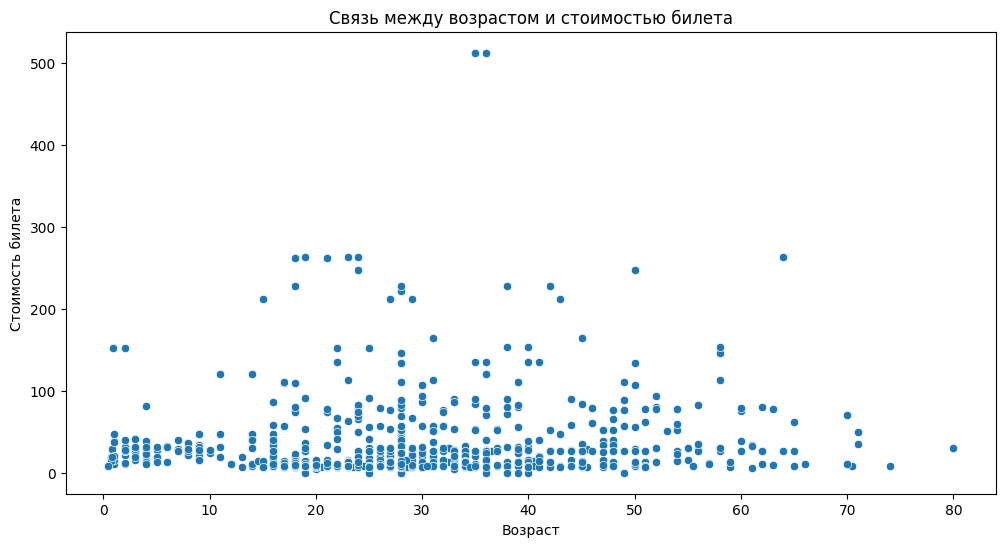

In [22]:
#зависит ли цена от возраста?
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Age', y='Fare', data=df)
plt.title('Связь между возрастом и стоимостью билета')
plt.xlabel('Возраст')
plt.ylabel('Стоимость билета')
plt.show()

In [23]:
#график оказался неинформативен, попробуем разбить возраст на подкатегории и посмотреть по ним информацию, а затем и изучить график
bins = [0, 18, 30, 50, np.inf]
labels = ['0-17', '18-29', '30-50', '50+']

df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

for group in labels:
    group_df = df[df['AgeGroup'] == group]
    print(f"\nАнализ для группы {group}:")
    print(group_df[['Age', 'Fare']].describe())
    
    correlation = group_df['Age'].corr(group_df['Fare'])
    print(f"Корреляционный коэффициент: {correlation:.2f}")
df['AgeGroupNumber'] = pd.Categorical(df['AgeGroup']).codes


Анализ для группы 0-17:
              Age        Fare
count  139.000000  139.000000
mean    10.717050   32.500721
std      6.465828   40.759691
min      0.420000    6.495800
25%      4.000000   10.816650
50%     13.000000   20.250000
75%     17.000000   32.193750
max     18.000000  262.375000
Корреляционный коэффициент: 0.02

Анализ для группы 18-29:
              Age        Fare
count  447.000000  447.000000
mean    25.902685   25.187274
std      3.186299   39.491625
min     19.000000    0.000000
25%     24.000000    7.795800
50%     28.000000    9.825000
75%     28.000000   25.466700
max     30.000000  263.000000
Корреляционный коэффициент: -0.04

Анализ для группы 30-50:
              Age        Fare
count  241.000000  241.000000
mean    38.734440   42.020453
std      5.732402   67.663779
min     30.500000    0.000000
25%     34.000000    8.662500
50%     38.000000   24.150000
75%     43.000000   52.000000
max     50.000000  512.329200
Корреляционный коэффициент: 0.04

Анализ для г

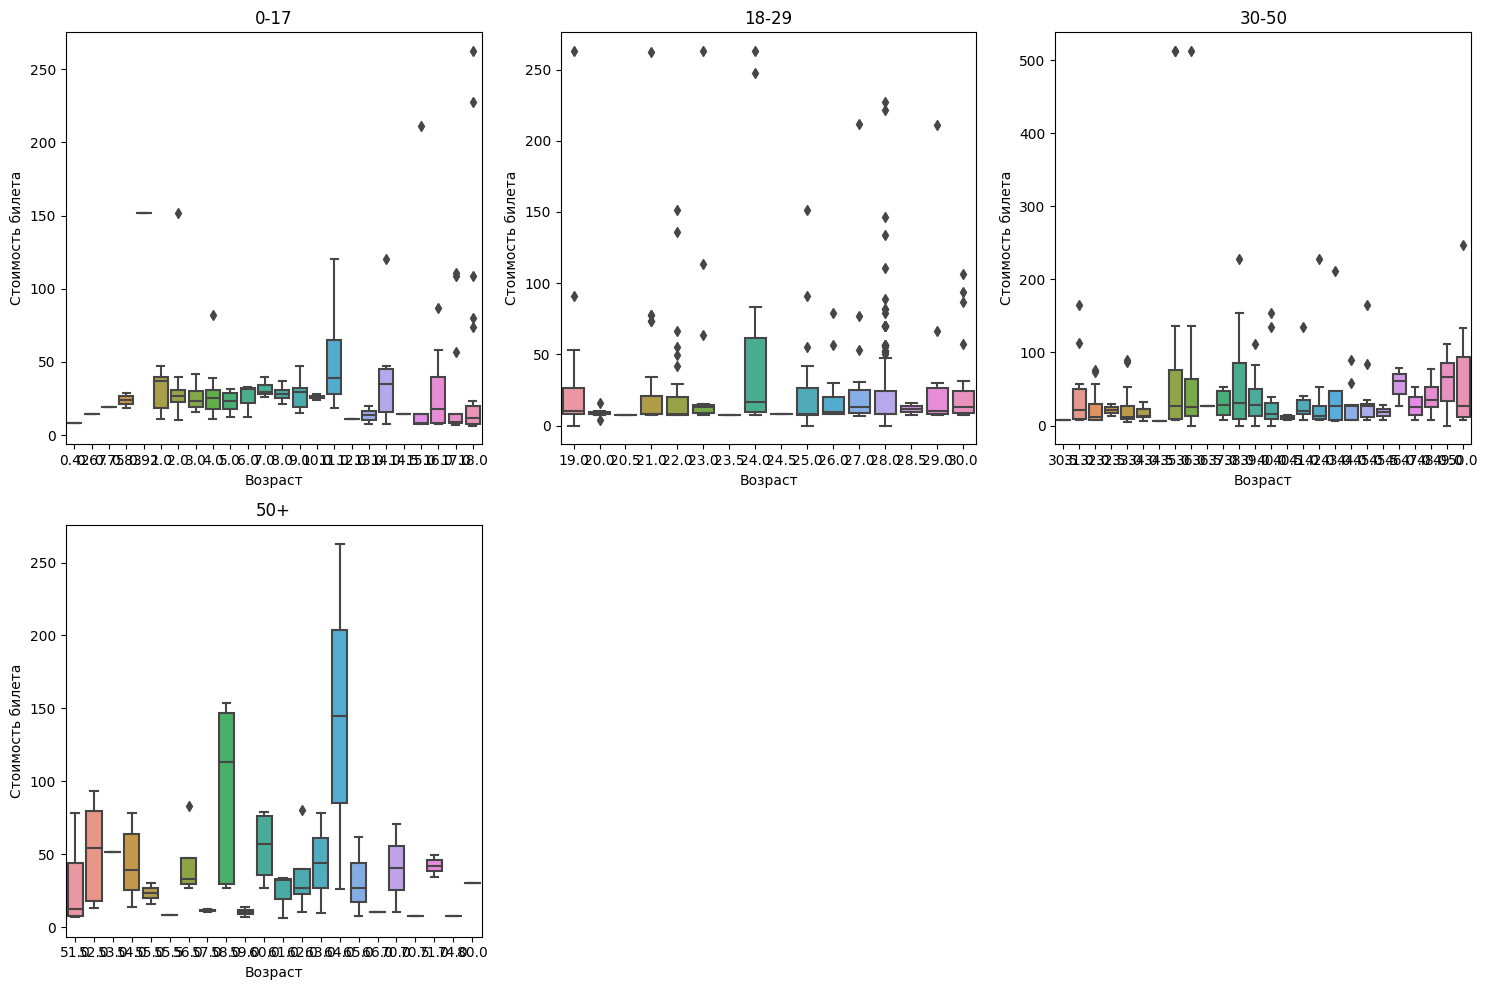

In [24]:
#график ясности мне не внес, поэтому эта ветка оказалась тупиковой
plt.figure(figsize=(15, 10))
for i, group in enumerate(labels):
    group_df = df[df['AgeGroup'] == group]
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Age', y='Fare', data=group_df)
    plt.title(f'{group}')
    plt.xlabel('Возраст')
    plt.ylabel('Стоимость билета')

plt.tight_layout()
plt.show()

In [25]:
#рассмотрим sibsp и parch думаю их лучше рассмотреть вместе для цельной картины
#проверим гипотезу, что одиноким пассажирам было проще спастись

lonely_persons = df[(df["SibSp"] == 0) & (df["Parch"] == 0)]
lonely_persons
print(f'всего одиноких людей было :{len(lonely_persons) / len(df) * 100}%')
alive = lonely_persons["Survived"].sum()
print(f"из них выжило: {alive / len(df) * 100}%")
#статистика говорит обратное! ровно наоборот, сильно понижался шанс если человек плыл один

всего одиноких людей было :60.26936026936027%
из них выжило: 18.29405162738496%


In [9]:
#гипотеза - многодетные семьи чаще всего были богатыми и выживали они с большей вероятностью, нежели одинокие пассажиры
#введем фичу, которая показывает общий размер семьи
df['FamilySize'] = df['SibSp'] + df['Parch']
#изучим процент выживаемости семьи


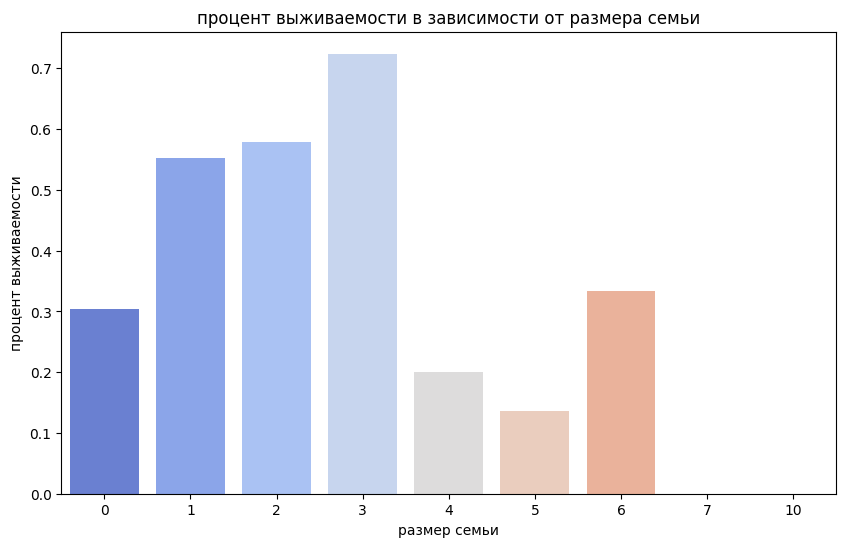

In [27]:
survival_rate = df.groupby('FamilySize')['Survived'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=survival_rate.index, y=survival_rate.values, palette='coolwarm')
plt.title('процент выживаемости в зависимости от размера семьи')
plt.xlabel('размер семьи')
plt.ylabel('процент выживаемости')

# Показать график
plt.show()

In [10]:
#добавим еще одну фичу, которая показывает один ли был человек на борту
df['HasFamily'] = df['FamilySize'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,HasFamily
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,0


In [11]:
#в фиче Name есть информация о титуле персоны, вытащим ее и проанализируем, возможно она как то влияет на статистику
tituls = df["Name"].apply(lambda name: name.split(',')[1].split('.')[0].strip())
df['Titul'] = tituls
tituls.value_counts()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,HasFamily,Titul
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,0,Mr


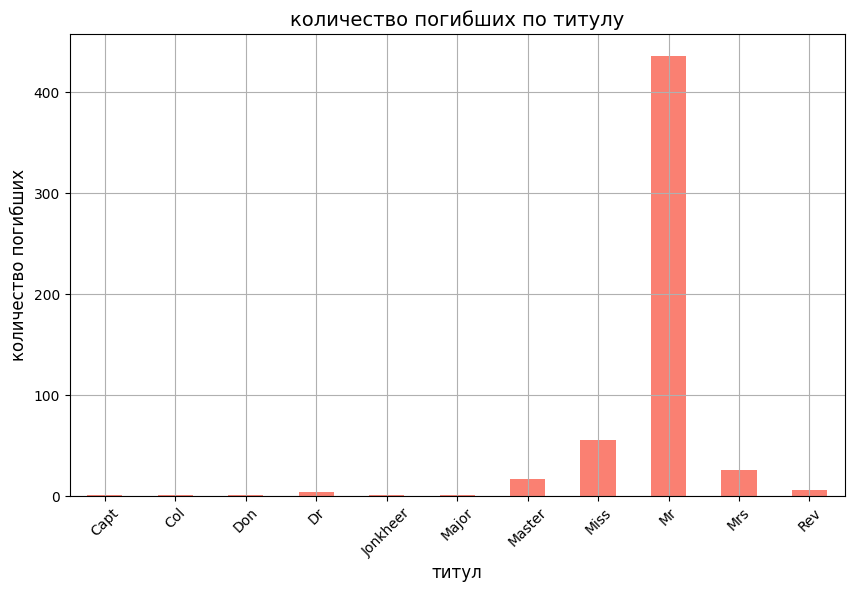

In [30]:
#график ясности не внес, посколько есть очень малочисленные и очень многочисленные группы
title_death_stats = df[df['Survived'] == 0].groupby('Titul')['Survived'].count()


plt.figure(figsize=(10, 6))
title_death_stats.plot(kind='bar', color='salmon')
plt.title('количество погибших по титулу', fontsize=14)
plt.xlabel('титул', fontsize=12)
plt.ylabel('количество погибших', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

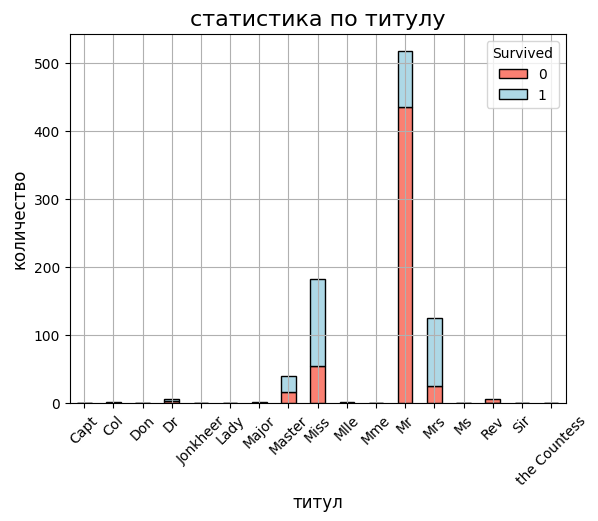

In [31]:
title_death_stats = df.groupby(['Titul', 'Survived'])['Survived'].count().unstack()
plt.figure(figsize=(12, 6))
title_death_stats.plot(kind='bar', stacked=True, color=['salmon', 'lightblue'], edgecolor='black')

plt.title('статистика по титулу', fontsize=16)
plt.xlabel('титул', fontsize=12)
plt.ylabel('количество', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
#данные вышли не очень информативными поскольку в т.н "элите" слишком мало погибших, обьединим ее в одну колонку и посмотрим еще раз

<Figure size 1200x600 with 0 Axes>

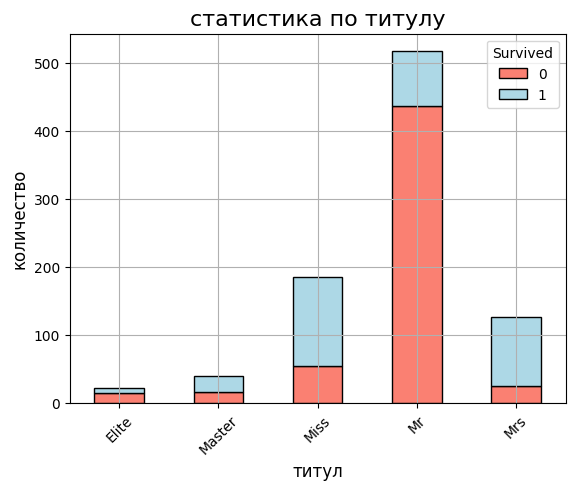

In [12]:
#для простоты обьединим в элиту всех пассажиров с чином. Mile, Mme сделаем Miss поскольку фактически это одна и та же группа людей, как и Ms -> Mrs
#здесь же проверим гипотезу, что элита выживала чаще(спойлер это не так)
elite_titles = ['Dr', 'Rev', 'Major', 'Col', 'the Countess', 'Capt', 'Sir', 'Lady', 'Don', 'Jonkheer']
df['Titul'] = df['Titul'].apply(lambda x: 'Elite' if x in elite_titles else x)
df['Titul'] = df['Titul'].replace({'Mlle': 'Miss', 'Mme': 'Miss', 'Ms' : 'Mrs'})
title_death_stats = df.groupby(['Titul', 'Survived'])['Survived'].count().unstack()
plt.figure(figsize=(12, 6))
title_death_stats.plot(kind='bar', stacked=True, color=['salmon', 'lightblue'], edgecolor='black')

plt.title('статистика по титулу', fontsize=16)
plt.xlabel('титул', fontsize=12)
plt.ylabel('количество', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

/tmp/ipykernel_30/4218568045.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Titul', y='Age', data=df, ci=None, palette='coolwarm')


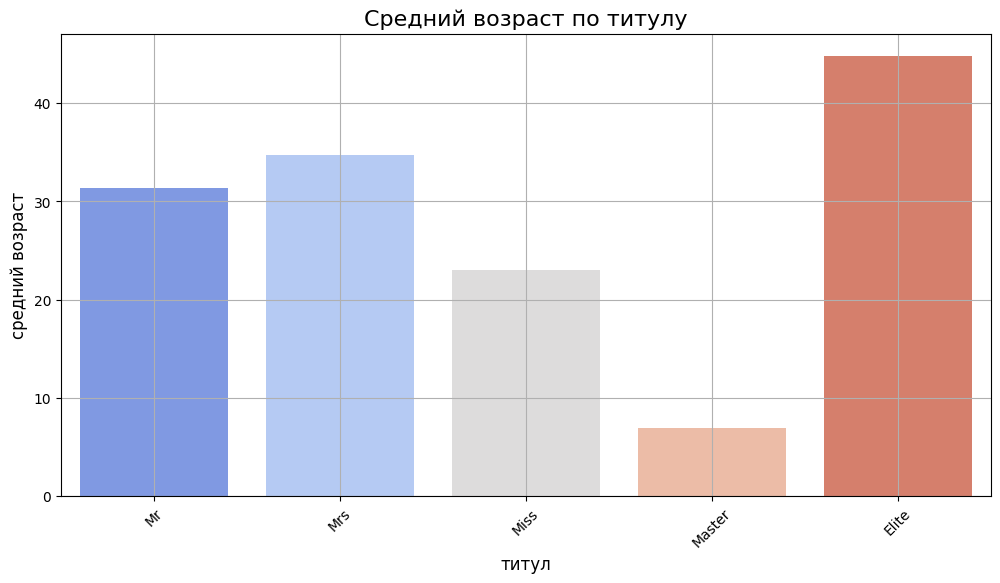

In [33]:
#из этого графика видно, что больше всего погибло обычных мужчин, mr давалось мужчине среднего возраста, 
# а среди выживаемости преобладают незамужние/замужние дамы и подростки(Master)
# из интересного, в статистике, большая часть элиты все же погибла.
plt.figure(figsize=(12, 6))
sns.barplot(x='Titul', y='Age', data=df, ci=None, palette='coolwarm')
plt.title('Средний возраст по титулу', fontsize=16)
plt.xlabel('титул', fontsize=12)
plt.ylabel('средний возраст', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
#кажется тут и кроется причина, большинство "элиты" было преклонного возраста


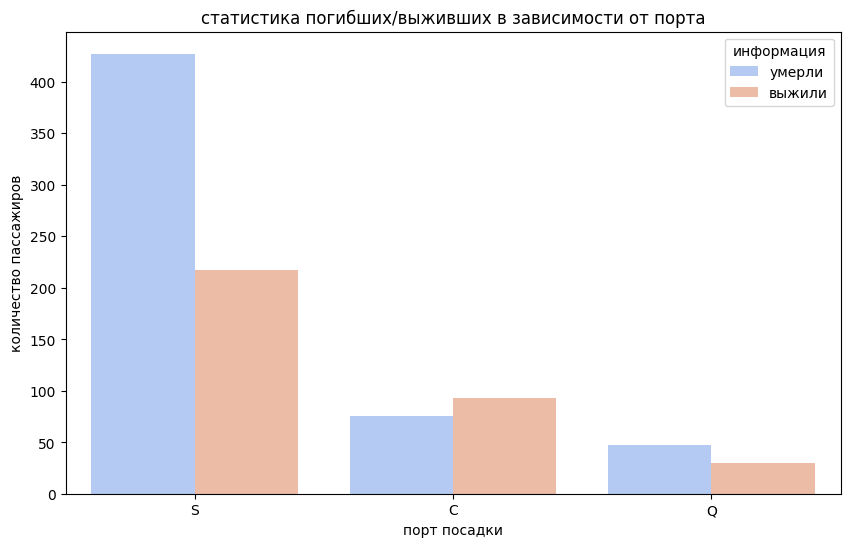

In [35]:
#самая неоднозначная фича, чувствую, что она никак не поможет модели, но изучить ее надо
#посмотрим оставшуюся фичу Embarked
# Создание графика по количеству выживших и погибших в зависимости от порта посадки
plt.figure(figsize=(10, 6))
sns.countplot(x='Embarked', hue='Survived', data=df, palette='coolwarm')
plt.title('статистика погибших/выживших в зависимости от порта')
plt.xlabel('порт посадки')
plt.ylabel('количество пассажиров')
plt.legend(title='информация', loc='upper right', labels=['умерли', 'выжили'])
plt.show()

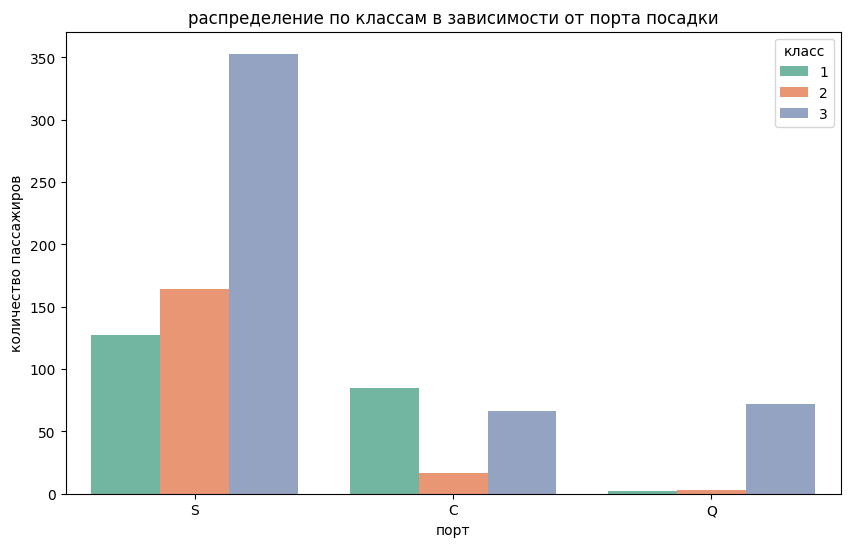

In [36]:
#видно что больше всего смертей с порта S
#можно предположить, что это в основном зависело от количества людей, которые выбрали первый класс и сели с конкретного порта, посмотрим это на графике
plt.figure(figsize=(10, 6))
sns.countplot(x='Embarked', hue='Pclass', data=df, palette='Set2')

# Настройка графика
plt.title('распределение по классам в зависимости от порта посадки')
plt.xlabel('порт')
plt.ylabel('количество пассажиров')
plt.legend(title='класс', loc='upper right')

# Показать график
plt.show()
#как видим большинство людей 3 класса село на порту S, собственно и погибших там много из за этого

In [13]:
# 2 этап - выборка фич для модели и постобработка
#применяем one-hot-encoding для Embarked и Titul
# не будем использовать PassengerId и Cabin, одна совершенно мусорная, другая неинформативного из за того что недостаточно данных
df.head()
# d_encoded = pd.get_dummies(df, columns=['Titul'])
# titul_columns = [col for col in df_encoded.columns if col.startswith('Titul_')]
# df_encoded[titul_columns] = df_encoded[titul_columns].astype(int)
# df_encoded.head()
feature_for_models = ["Survived", "Pclass", "Sex", "Age", "FamilySize", "HasFamily", "Fare", "Embarked", "Titul"]
df_model = df[feature_for_models]
df_model = pd.get_dummies(df_model, columns=['Titul'])
titul_columns = [col for col in df_model.columns if col.startswith('Titul_')]
df_model[titul_columns] = df_model[titul_columns].astype(int)
df_model = pd.get_dummies(df_model, columns=['Embarked'], prefix='Embarked')
emb_columns = [col for col in df_model.columns if col.startswith('Embarked_')]
df_model[emb_columns] = df_model[emb_columns].astype(int)
df_model.head()

,Survived,Pclass,Sex,Age,FamilySize,HasFamily,Fare,Titul_Elite,Titul_Master,Titul_Miss,Titul_Mr,Titul_Mrs,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,1,7.2500,0,0,0,1,0,0,0,1
1,1,1,0,38.0,1,1,71.2833,0,0,0,0,1,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,1
3,1,1,0,35.0,1,1,53.1000,0,0,0,0,1,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,0,1,0,0,0,1


In [144]:
X = df_model.drop('Survived', axis=1)
y = df_model['Survived']
X

,Pclass,Sex,Age,FamilySize,HasFamily,Fare,Titul_Elite,Titul_Master,Titul_Miss,Titul_Mr,Titul_Mrs,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.0,1,1,7.2500,0,0,0,1,0,0,0,1
1,1,0,38.0,1,1,71.2833,0,0,0,0,1,1,0,0
2,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,1
3,1,0,35.0,1,1,53.1000,0,0,0,0,1,0,0,1
4,3,1,35.0,0,0,8.0500,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,1,0,0,0,0,0,0,1
887,1,0,19.0,0,0,30.0000,0,0,1,0,0,0,0,1
888,3,0,28.0,3,1,23.4500,0,0,1,0,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,0,0,1,0,1,0,0


In [133]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#разобьем на тестовую и валидационную выборку при помощи scikit-learn
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)
X_train

array([[  1.    ,   1.    ,  28.5   ,   0.    ,   1.    ,   0.    ],
       [  2.    ,   1.    ,  13.    ,   0.    ,   1.    ,   0.    ],
       [  3.    ,   1.    ,   7.925 ,   0.    ,   1.    ,   0.    ],
       ...,
       [  3.    ,   1.    ,  14.1083,   0.    ,   1.    ,   0.    ],
       [  1.    ,   0.    , 120.    ,   1.    ,   0.    ,   0.    ],
       [  1.    ,   1.    ,  77.2875,   0.    ,   1.    ,   0.    ]])

In [19]:
from keras.models import Sequential
from keras.layers import Dense

In [134]:
#построим простенькую нейронку просто для проверки
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6256 - loss: 0.7892 - val_accuracy: 0.7273 - val_loss: 0.5924
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6741 - loss: 0.6426 - val_accuracy: 0.6923 - val_loss: 0.6147
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7334 - loss: 0.5868 - val_accuracy: 0.7343 - val_loss: 0.5394
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7178 - loss: 0.5672 - val_accuracy: 0.7692 - val_loss: 0.5091
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7226 - loss: 0.5496 - val_accuracy: 0.7762 - val_loss: 0.5379
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7242 - loss: 0.5539 - val_accuracy: 0.7552 - val_loss: 0.5623
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7240 - loss: 0.5539 - val_accuracy: 0.7762 - val_loss: 0.4749
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6911 - loss: 0.5783 - val_accuracy: 0.8112 - val_loss

In [136]:
#посмотрим метрики на данный момент
from sklearn.metrics import classification_report
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_val, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       105
           1       0.77      0.68      0.72        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



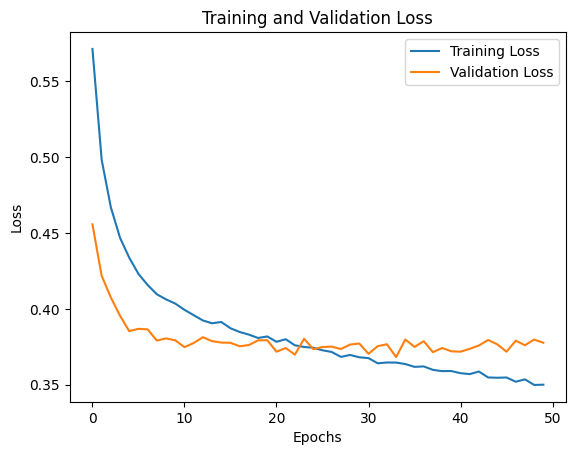

In [22]:
#и изменение Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [86]:
res = model.evaluate(X_test, y_test, verbose=0)
res
#как видим, accuracy небольшой, будем оптимизировать модельку

[0.4541168212890625, 0.7374301552772522]

In [23]:
#тут были первые попытки, не особо удачные, поскольку использовал не ту score_func
from sklearn.feature_selection import SelectKBest, chi2
#узнаем какие фичи наиболее важны
selector = SelectKBest(score_func=chi2, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)

ValueError: Input X must be non-negative.

In [68]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(X_train_selected.shape[1],)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train_selected, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5675 - loss: 1.5713 - val_accuracy: 0.6713 - val_loss: 0.8944
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6494 - loss: 0.8388 - val_accuracy: 0.7063 - val_loss: 0.6837
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6965 - loss: 0.6375 - val_accuracy: 0.7203 - val_loss: 0.6161
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6807 - loss: 0.6165 - val_accuracy: 0.7133 - val_loss: 0.5781
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7025 - loss: 0.6003 - val_accuracy: 0.7343 - val_loss: 0.5466
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7358 - loss: 0.5303 - val_accuracy: 0.7063 - val_loss: 0.5305
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7513 - loss: 0.5413 - val_accuracy: 0.7552 - val_loss: 0.5167
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7183 - loss: 0.5581 - val_accuracy: 0.7343 - val_loss

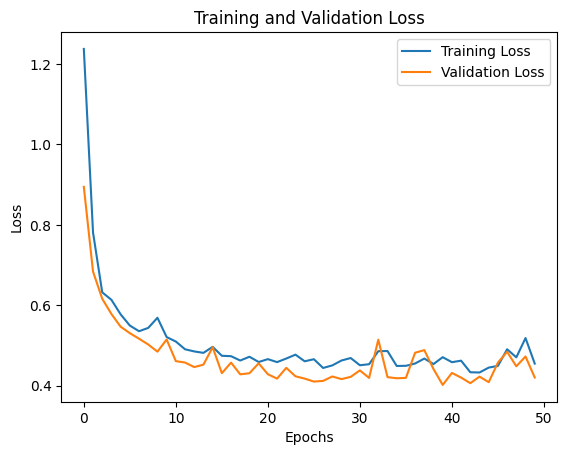

In [71]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [85]:
#глобально, ничего не изменилось, попробуем подобрать гиперпараметры и фичи автоматически
res = model.evaluate(X_test, y_test, verbose=0)
res

[0.4541168212890625, 0.7374301552772522]

In [63]:
!pip install keras-tuner

In [25]:
#в начале решил попробовать подобрать гиперпараметры, такие как количество слоев, количество unit на каждом слое и learning rate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
def build_model(hp):
    model = Sequential()
    
    model.add(
        Dense(
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            activation="relu"
        )
    )
    for i in range(hp.Int("num_layers", 1, 20)):
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu"
            )
        )
    model.add(layers.Dense(1, activation="sigmoid"))
    learning_rate = hp.Choice("learning_rate", [0.001, 0.01, 0.1])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model
    

In [26]:
import keras_tuner as kt
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    directory="my_dir",
    project_name="hyperparam_tuning"
)

In [27]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.7597765326499939

Best val_accuracy So Far: 0.7597765326499939
Total elapsed time: 00h 01m 39s


In [158]:
#вот такие параметры я получил, в будущем они мне помогут в обратную сторону
best_model = tuner.get_best_models(num_models=1)[0]

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'units': 192, 'num_layers': 9, 'units_0': 512, 'learning_rate': 0.001, 'units_1': 512, 'units_2': 320, 'units_3': 288, 'units_4': 32, 'units_5': 192, 'units_6': 192, 'units_7': 448, 'units_8': 416, 'units_9': 512, 'units_10': 128, 'units_11': 96, 'units_12': 160, 'units_13': 160, 'units_14': 32, 'units_15': 128, 'units_16': 352, 'units_17': 128, 'units_18': 96}


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [145]:
#затем я решил выделить топ 6 самых важных фич, чтобы использовать уже только их, в целом они оказались практически предсказуемы
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X_train, y_train)
important_features = X_train.columns[selector.get_support()]
important_features


Index(['Pclass', 'Sex', 'Fare', 'Titul_Miss', 'Titul_Mr', 'Titul_Mrs'], dtype='object')

In [146]:
X = df_model[important_features]


In [147]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [61]:
!pip install keras

In [71]:
# def final_model():
#     model = Sequential()
#     units = [512, 512, 320, 288, 32,192, 192, 448, 416, 512, 128, 96, 160, 160, 32, 128, 352, 128, 96]
#     model.add(Dense(units=192, activation='relu', input_shape=(X_train.shape[1],)))
#     for unit in units:
#         model.add(Dense(units=unit, activation='relu'))
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model
# model = final_model()
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
def get_model():
    model = Sequential()
    model.add(Dense(units=192, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=320, activation='relu'))
    model.add(Dense(units=288, activation='relu'))
    model.add(Dense(units=192, activation='relu'))
    model.add(Dense(units=192, activation='relu'))
    model.add(Dense(units=448, activation='relu'))
    model.add(Dense(units=416, activation='relu'))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=96, activation='relu'))
    model.add(Dense(units=160, activation='relu'))
    model.add(Dense(units=160, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=352, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=96, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = get_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5588 - loss: 0.6913 - val_accuracy: 0.6923 - val_loss: 0.6604
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6464 - loss: 0.6568 - val_accuracy: 0.6503 - val_loss: 0.6360
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6129 - loss: 0.6618 - val_accuracy: 0.6993 - val_loss: 0.6129
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6816 - loss: 0.6103 - val_accuracy: 0.7133 - val_loss: 0.5421
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6770 - loss: 0.5849 - val_accuracy: 0.7413 - val_loss: 0.5075
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6750 - loss: 0.5609 - val_accuracy: 0.7552 - val_loss: 0.5040
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7178 - loss: 0.5959 - val_accuracy: 0.6503 - val_loss: 0.6829
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6119 - loss: 0.6838 - val_accuracy: 0.6503 - v

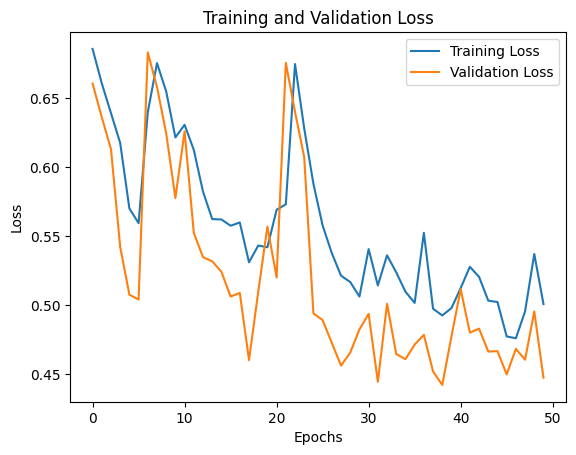

In [72]:
#итак, после подбора параметров произошло переобучение модели, как следствие ужасное изменение loss и достаточно приемлемый accuracy, но так не пойдет
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
res = model.evaluate(X_test, y_test, verbose=0)
res

[0.5049054622650146, 0.7765362858772278]

In [87]:
#в итоге предыдущая оптимизация сильно ухудшила разброс, теперь попробуем другую методику, упростим немного модель, уменьшив число слоев и юнитов. добавим Dropout слой, основная идея которого заключается в случайном «выключении» (то есть временном исключении из обучения) определенного процента нейронов в сети на каждом шаге обучения. Это означает, что во время каждого прохода обучения (или каждой эпохи) случайно выбранный набор нейронов игнорируется. Это помогает предотвратить чрезмерную зависимость модели от конкретных путей и узлов в сети, что может привести к переобучению.
#также на каждом слое добавим BatchNormalization, которая нормализирует количество выходов после каждого слоя.Нормализация заключается в преобразовании входных данных каждого слоя таким образом, чтобы среднее значение было приближено к нулю, а стандартное отклонение — к единице. Это делает сеть менее чувствительной к масштабу входных данных и улучшает общую стабильность процесса обучения.

from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
def get_optimized_model():
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = get_optimized_model()
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5873 - loss: 0.7925 - val_accuracy: 0.6573 - val_loss: 0.6812
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7169 - loss: 0.6177 - val_accuracy: 0.6573 - val_loss: 0.6653
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6975 - loss: 0.6375 - val_accuracy: 0.6783 - val_loss: 0.6066
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7255 - loss: 0.6018 - val_accuracy: 0.6923 - val_loss: 0.6359
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7546 - loss: 0.5824 - val_accuracy: 0.6923 - val_loss: 0.6049
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7115 - loss: 0.6142 - val_accuracy: 0.6503 - val_loss: 0.6026
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7324 - loss: 0.5993 - val_accuracy: 0.6993 - val_loss: 0.6136
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7426 - loss: 0.5279 - val_accuracy: 0.6434 - val_loss

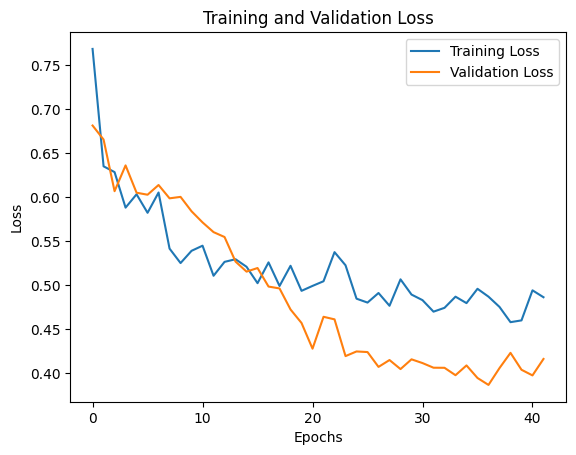

In [88]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
res = model.evaluate(X_test, y_test, verbose=0)
res

[0.4226609170436859, 0.7932960987091064]

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [121]:
#вынесем итоговую модель для удобства
def final_model():
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(X.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [156]:
#кросс валидация при помощи KFold
#на предыдущем шаге мы получили более менее оптимальную модель, теперь проведем для нее кросс-валидацию
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
fold_num = 1
kfold = KFold(n_splits=3, shuffle=True)

for train_index, val_index in kfold.split(X):
    print(f"\nFold {fold_num}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = final_model()
    model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=0)
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    
    fold_num+=1
    
    
    
    


Fold 1


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.70      0.97      0.82       177
           1       0.90      0.39      0.55       120

    accuracy                           0.74       297
   macro avg       0.80      0.68      0.68       297
weighted avg       0.78      0.74      0.71       297

[[172   5]
 [ 73  47]]

Fold 2


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       189
           1       0.75      0.65      0.70       108

    accuracy                           0.79       297
   macro avg       0.78      0.76      0.77       297
weighted avg       0.79      0.79      0.79       297

[[166  23]
 [ 38  70]]

Fold 3


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       183
           1       0.75      0.68      0.71       114

    accuracy                           0.79       297
   macro avg       0.78      0.77      0.77       297
weighted avg       0.79      0.79      0.79       297

[[158  25]
 [ 37  77]]


In [ ]:
#выводы по матрице ошибок
# на основе анализа матрицы ошибок и классификационного репорта можно сделать следующие выводы
# модель предсказала, что пассажир выжил, и он действительно выжил суммарно по 3 фолдам 496 человек - мера TP. Модель предсказала, что пассажир погиб, и он погиб суммарно по 3 фолдам 194- мера TN.
#модель неверно предсказала, что пассажир выжил, а он погиб суммарно по 3 фолдам 148 человек - мера FP. модель неверно предсказала, что пассажир погиб, а он на самом деле выжил, суммарно по 3 фолдам 53 человека - мера FN


In [ ]:
#итоговые выводы
#в ходе аналитики параметров, добавления новых переменных а затем создания модели с ее дальнейшей калибровкой, мне удалось создать нейронную сеть на основе keras.Sequential с итоговым accuracy на валидационной выборке 0.79.